Iteration 20/200, Best Fitness = 0.001419
Iteration 40/200, Best Fitness = 0.201891
Iteration 60/200, Best Fitness = 0.492899
Iteration 80/200, Best Fitness = 0.041920
Iteration 100/200, Best Fitness = 0.046817
Iteration 120/200, Best Fitness = 0.517403
Iteration 140/200, Best Fitness = 0.226545
Iteration 160/200, Best Fitness = 0.031793
Iteration 180/200, Best Fitness = 0.080682
Iteration 200/200, Best Fitness = 0.085223

Best Solution Found: [-0.01221647 -0.0167529 ]
Best Fitness: 0.08522348416673964


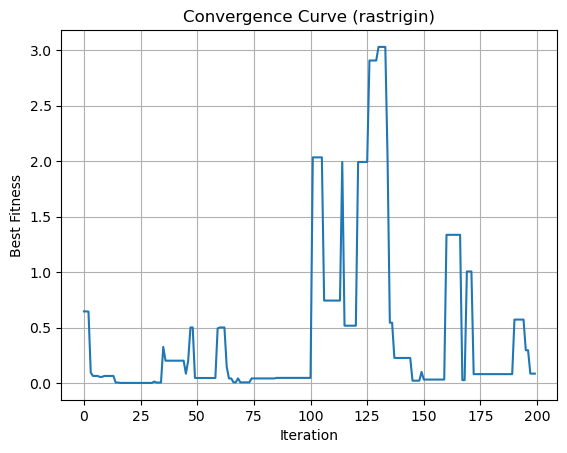

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# =========================================
# Benchmark Functions
# =========================================
def sphere(x):
    return np.sum(x**2)

def rastrigin(x):
    return 10 * len(x) + np.sum(x**2 - 10 * np.cos(2 * np.pi * x))

def rosenbrock(x):
    return np.sum(100*(x[1:] - x[:-1]**2)**2 + (1 - x[:-1])**2)

# =========================================
# Helper Functions
# =========================================
def random_solution(bounds):
    lower, upper = bounds
    return np.random.uniform(lower, upper)

def mutate(x, bounds, strength=0.1):
    lower, upper = bounds
    x_new = x + strength * np.random.randn(*x.shape)
    return np.clip(x_new, lower, upper)

def get_neighbors_indices(i, j, N_rows, N_cols):
    # Von Neumann neighborhood (4 neighbors, wrap around grid)
    return [
        ((i - 1) % N_rows, j),
        ((i + 1) % N_rows, j),
        (i, (j - 1) % N_cols),
        (i, (j + 1) % N_cols)
    ]

# =========================================
# Parallel Cellular Algorithm
# =========================================
def parallel_cellular_algorithm_2d(
    f,
    bounds=(-5.12, 5.12),
    N_rows=10,
    N_cols=10,
    T_max=100,
    λ=0.5,
    p_mut=0.1,
    dim=2
):
    # Step 1: Initialize population grid
    grid = np.empty((N_rows, N_cols), dtype=object)
    for i in range(N_rows):
        for j in range(N_cols):
            x = random_solution(bounds) * np.ones(dim)
            fitness = f(x)
            grid[i, j] = {'x': x, 'fitness': fitness}

    # For tracking progress
    best_fitness_list = []

    # Step 2: Iterative optimization
    for t in range(T_max):
        new_grid = np.empty_like(grid)

        for i in range(N_rows):
            for j in range(N_cols):
                cell = grid[i, j]
                neighbors_idx = get_neighbors_indices(i, j, N_rows, N_cols)
                neighbors = [grid[p][q] for p, q in neighbors_idx]

                # Find best neighbor
                best_neighbor = min(neighbors, key=lambda c: c['fitness'])

                # Diffusion update
                if best_neighbor['fitness'] < cell['fitness']:
                    diff_sum = np.zeros(dim)
                    for p, q in neighbors_idx:
                        diff_sum += (grid[p, q]['x'] - cell['x'])
                    x_new = cell['x'] + λ * diff_sum / len(neighbors_idx)
                else:
                    x_new = cell['x'].copy()

                # Mutation
                if np.random.rand() < p_mut:
                    x_new = mutate(x_new, bounds)

                # Update fitness
                new_grid[i, j] = {'x': x_new, 'fitness': f(x_new)}

        # Replace old grid with new grid
        grid = new_grid

        # Track best fitness
        best_cell = min([grid[i, j] for i in range(N_rows) for j in range(N_cols)],
                        key=lambda c: c['fitness'])
        best_fitness_list.append(best_cell['fitness'])

        # Print progress occasionally
        if (t+1) % (T_max//10) == 0:
            print(f"Iteration {t+1}/{T_max}, Best Fitness = {best_cell['fitness']:.6f}")

    # Final best solution
    best_cell = min([grid[i, j] for i in range(N_rows) for j in range(N_cols)],
                    key=lambda c: c['fitness'])

    return best_cell['x'], best_cell['fitness'], best_fitness_list


# =========================================
# Run Example
# =========================================
if __name__ == "__main__":
    np.random.seed(42)

    # Choose function here
    func = rastrigin
    bounds = (-5.12, 5.12)

    best_x, best_f, history = parallel_cellular_algorithm_2d(
        f=func,
        bounds=bounds,
        N_rows=10,
        N_cols=10,
        T_max=200,
        λ=0.4,
        p_mut=0.1,
        dim=2
    )

    print("\nBest Solution Found:", best_x)
    print("Best Fitness:", best_f)

    # Plot convergence
    plt.plot(history)
    plt.title(f"Convergence Curve ({func.__name__})")
    plt.xlabel("Iteration")
    plt.ylabel("Best Fitness")
    plt.grid(True)
    plt.show()
